# Initial Setup and Library Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import joblib
from joblib import Parallel, delayed

import os

import warnings
warnings.filterwarnings('ignore')

# Data Loading and Preparation

In [2]:
df_train = pd.read_csv('dataset/exoTrain.csv')
df_test = pd.read_csv('dataset/exoTest.csv')

df = pd.concat([df_train, df_test], ignore_index=True)

In [3]:
df_train = pd.read_csv('dataset/exoTrain.csv')
df_test = pd.read_csv('dataset/exoTest.csv')
df = pd.concat([df_train, df_test], ignore_index=True)

X = df.drop('LABEL', axis=1)
y = df['LABEL']
y_prepared = (y - 1).values

X_prepared = X.values
X_prepared = np.expand_dims(X_prepared, axis=1)

print("--- Data Loading and Preparation Complete ---")
print(f"Total number of samples: {len(df)}")
print(f"Shape of the feature data (X): {X_prepared.shape}")
print(f"Shape of the label data (y): {y_prepared.shape}")
print(f"Type of y_prepared: {type(y_prepared)}")

--- Data Loading and Preparation Complete ---
Total number of samples: 5657
Shape of the feature data (X): (5657, 1, 3197)
Shape of the label data (y): (5657,)
Type of y_prepared: <class 'numpy.ndarray'>


# Exploratory Data Analysis: Target Variable Distribution

--- Target Variable Distribution ---
Counts:
LABEL
1    5615
2      42
Name: count, dtype: int64

Percentages:
LABEL
1    99.257557
2     0.742443
Name: proportion, dtype: float64


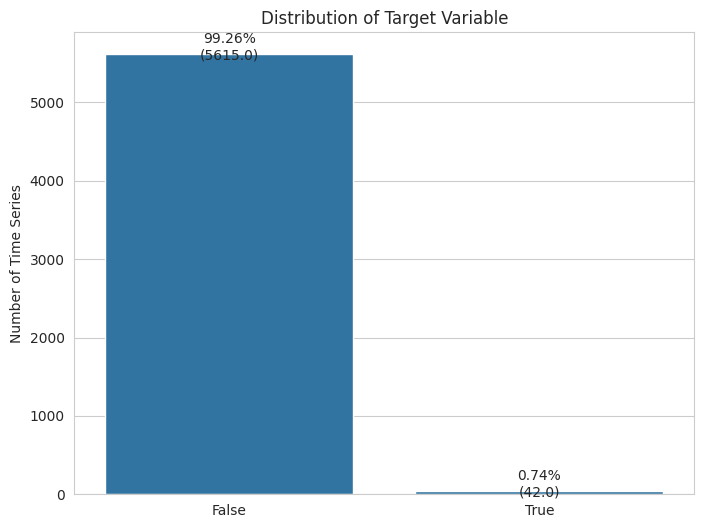

In [4]:
target_counts = y.value_counts()
target_percentages = y.value_counts(normalize=True) * 100

print("--- Target Variable Distribution ---")
print("Counts:")
print(target_counts)
print("\nPercentages:")
print(target_percentages)

sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=y_prepared)

for p in ax.patches:
    percentage = f'{100 * p.get_height() / len(y_prepared):.2f}%\n({p.get_height()})'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Target Variable')
plt.ylabel('Number of Time Series')
plt.xticks([0, 1], ['False', 'True'])
plt.show()

# Importing Deep Learning Libraries and Modules

In [5]:
import sklearn
import numpy as np
import pandas as pd
import torch
from torch import nn
from models import TimerBackbone

from torch.amp import GradScaler, autocast 

import json
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

import joblib
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader, Sampler 
from scipy.stats import entropy as spectral_entropy
import pyentrp

import random

from sklearn.model_selection import StratifiedKFold
import gc 

2025-10-05 17:31:55.748882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759667515.763532   37349 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759667515.767796   37349 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759667515.783551   37349 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759667515.783581   37349 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759667515.783583   37349 computation_placer.cc:177] computation placer alr

# Dataset preparation

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, y_prepared, test_size=0.1, random_state=42, stratify=y_prepared
)

In [7]:
class ExoDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Model Architecture

In [ ]:
class Model(nn.Module):
    def __init__(self, configs):
        super().__init__()
        self.task_name = configs.task_name
        self.backbone = TimerBackbone.Model_RWKV7(configs)

        self.classification_head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(configs.d_model, 1)
        )
        
        self.decoder = self.backbone.decoder
        self.proj = self.backbone.proj
        self.enc_embedding = self.backbone.patch_embedding

    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        B, L, M = x_enc.shape

        # Normalization from Non-stationary Transformer
        means = x_enc.mean(1, keepdim=True).detach()
        x_enc = x_enc - means
        stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5).detach()
        x_enc /= stdev

        # do patching and embedding
        x_enc = x_enc.permute(0, 2, 1) # [B, M, T]
        dec_in, n_vars = self.enc_embedding(x_enc) # [B * M, N, D]
        # print(dec_in.shape)

        # RWKV7 Blocks
        dec_out, attns = self.decoder(dec_in) # [B * M, N, D]
        dec_out = self.proj(dec_out) # [B * M, N, L]
        dec_out = dec_out.reshape(B, M, -1).transpose(1, 2) # [B, T, M]

        # De-Normalization from Non-stationary Transformer
        dec_out = dec_out * stdev + means
        if self.output_attention:
            return dec_out, attns
        return dec_out

    def imputation(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        B, L, M = x_enc.shape
        # Normalization from Non-stationary Transformer
        means = torch.sum(x_enc, dim=1) / torch.sum(mask == 1, dim=1)
        means = means.unsqueeze(1).detach()
        x_enc = x_enc - means
        x_enc = x_enc.masked_fill(mask == 0, 0)
        stdev = torch.sqrt(torch.sum(x_enc * x_enc, dim=1) /
                           torch.sum(mask == 1, dim=1) + 1e-5)
        stdev = stdev.unsqueeze(1).detach()
        x_enc /= stdev

        # do patching and embedding
        x_enc = x_enc.permute(0, 2, 1) # [B, M, T]
        dec_in, n_vars = self.enc_embedding(x_enc) # [B * M, N, D]

        # Transformer Blocks
        dec_out, attns = self.decoder(dec_in) # [B * M, N, D]
        dec_out = self.proj(dec_out) # [B * M, N, L]
        dec_out = dec_out.reshape(B, M, -1).transpose(1, 2) # [B, T, M]

        # De-Normalization from Non-stationary Transformer
        dec_out = dec_out * stdev + means
        return dec_out

    def anomaly_detection(self, x_enc):
        B, L, M = x_enc.shape

        # Normalization from Non-stationary Transformer
        means = x_enc.mean(1, keepdim=True).detach()
        x_enc = x_enc - means
        stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5).detach()
        x_enc /= stdev

        # do patching and embedding
        x_enc = x_enc.permute(0, 2, 1) # [B, M, T]
        dec_in, n_vars = self.enc_embedding(x_enc) # [B * M, N, D]

        # Transformer Blocks
        dec_out, attns = self.decoder(dec_in) # [B * M, N, D]
        dec_out = self.proj(dec_out) # [B * M, N, L]
        dec_out = dec_out.reshape(B, M, -1).transpose(1, 2) # [B, T, M]

        # De-Normalization from Non-stationary Transformer
        dec_out = dec_out * stdev + means
        return dec_out

    def classification(self, x_enc):
        B, M, L = x_enc.shape

        means = x_enc.mean(2, keepdim=True).detach()
        x_enc = x_enc - means
        stdev = torch.sqrt(torch.var(x_enc, dim=2, keepdim=True, unbiased=False) + 1e-5).detach()
        x_enc /= stdev

        enc_out, n_vars = self.backbone.patch_embedding(x_enc)
        enc_out, attns = self.backbone.decoder(enc_out)
        
        output = enc_out.reshape(B, M, -1, self.backbone.d_model)
        output = output.mean(dim=1)
        output = output.permute(0, 2, 1)

        output = self.classification_head(output)

        return output

    def forward(self, x_enc, x_mark_enc=None, x_dec=None, x_mark_dec=None, mask=None):
        if self.task_name == 'classification':
            dec_out = self.classification(x_enc)
            return dec_out
        if self.task_name == 'forecast':
            dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
            return dec_out  # [B, T, D]
        if self.task_name == 'imputation':
            dec_out = self.imputation(
                x_enc, x_mark_enc, x_dec, x_mark_dec, mask)
            return dec_out  # [B, T, D]
        if self.task_name == 'anomaly_detection':
            dec_out = self.anomaly_detection(x_enc)
            return dec_out  # [B, T, D]

        raise NotImplementedError

# Training

In [9]:
def train_fold(fold_num, X_train_fold, y_train_fold, X_val_fold, y_val_fold, config):
    print(f"\n{'='*25} FOLD {fold_num+1} {'='*25}")
    
    class Configs:
        def __init__(self, config_dict):
            for key, value in config_dict.items():
                setattr(self, key, value)

    configs = Configs(config)
    
    model = Model(configs).cuda()
    train_dataset = ExoDataset(X_train_fold, y_train_fold)
    val_dataset = ExoDataset(X_val_fold, y_val_fold)
    
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'], pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'], pin_memory=True)
    
    print(f"Data for fold {fold_num+1} loaded: {len(train_dataset)} train, {len(val_dataset)} val samples.")
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=config['epoch'], eta_min=1e-6)
    
    counts = pd.Series(y_train_fold).value_counts()
    pos_weight_value = counts.get(0, 1) / counts.get(1, 1)
    pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float32).cuda()
    loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
    
    scaler = GradScaler()
    
    best_model_path = f"{config['save_ckpt_path']}/best_model_fold_{fold_num+1}.pth"
    best_val_auc = -1
    patience = 5
    patience_counter = 0

    for epoch in range(config['epoch']):
        model.train()
        total_loss = 0
        all_preds, all_targets = [], []
        current_lr = optimizer.param_groups[0]['lr']
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config["epoch"]} (LR: {current_lr:.6f})')

        for batch in progress_bar:
            input_x, gt = batch
            input_x = input_x.cuda()
            gt = gt.cuda().float().unsqueeze(1)

            with autocast("cuda"):
                output = model(input_x)
                loss = loss_function(output, gt)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            all_preds.extend(torch.sigmoid(output).cpu().detach().numpy())
            all_targets.extend(gt.cpu().detach().numpy())
            progress_bar.set_postfix(loss=loss.item())

        scheduler.step()
        train_auc = roc_auc_score(all_targets, all_preds)
        
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_x, gt = batch
                input_x = input_x.cuda()
                gt = gt.cuda().float().unsqueeze(1)
                with autocast("cuda"):
                    output = model(input_x)
                val_preds.extend(torch.sigmoid(output).cpu().numpy())
                val_targets.extend(gt.cpu().numpy())

        val_auc = roc_auc_score(val_targets, val_preds)
        print(f"\nEpoch {epoch+1} Summary: Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")

        if val_auc > best_val_auc:
            print(f"--> Val AUC improved from {best_val_auc:.4f} to {val_auc:.4f}. Saving model...")
            best_val_auc = val_auc
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"--> No improvement. Patience: {patience_counter}/{patience}. Best AUC: {best_val_auc:.4f}")

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break
            
    del model, train_loader, val_loader, train_dataset, val_dataset
    gc.collect()
    torch.cuda.empty_cache()

    return best_val_auc

def run_training_cv(X_data, y_data, config):
    if not os.path.exists(config['save_ckpt_path']):
        os.makedirs(config['save_ckpt_path'])

    N_SPLITS = 5
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    oof_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_data, y_data)):
        
        # Split the data using the indices from StratifiedKFold
        X_train_fold, X_val_fold = X_data[train_idx], X_data[val_idx]
        y_train_fold, y_val_fold = y_data[train_idx], y_data[val_idx]
        
        best_fold_auc = train_fold(
            fold_num=fold,
            X_train_fold=X_train_fold, y_train_fold=y_train_fold,
            X_val_fold=X_val_fold, y_val_fold=y_val_fold,
            config=config
        )
        oof_scores.append(best_fold_auc)

    print(f"\n{'='*25} CROSS-VALIDATION FINISHED {'='*25}")
    print(f"Scores for each fold: {[f'{score:.4f}' for score in oof_scores]}")
    print(f"Mean CV AUC: {np.mean(oof_scores):.4f}")
    print(f"Std Dev CV AUC: {np.std(oof_scores):.4f}")

In [10]:
with open('config.json', 'r') as f:
    config = json.load(f)

run_training_cv(X_train, y_train, config=config)


========================= FOLD 1 =========================
Data for fold 1 loaded: 4072 train, 1019 val samples.


Epoch 1/20 (LR: 0.000100): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [01:06<00:00,  2.04it/s, loss=4.2]



Epoch 1 Summary: Train AUC: 0.4463 | Val AUC: 0.5739
--> Val AUC improved from -1.0000 to 0.5739. Saving model...


Epoch 2/20 (LR: 0.000099): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 34.73it/s, loss=0.688]



Epoch 2 Summary: Train AUC: 0.3734 | Val AUC: 0.5842
--> Val AUC improved from 0.5739 to 0.5842. Saving model...


Epoch 3/20 (LR: 0.000098): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 36.55it/s, loss=8.48]



Epoch 3 Summary: Train AUC: 0.4899 | Val AUC: 0.6771
--> Val AUC improved from 0.5842 to 0.6771. Saving model...


Epoch 4/20 (LR: 0.000095): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 36.91it/s, loss=0.764]



Epoch 4 Summary: Train AUC: 0.5564 | Val AUC: 0.7096
--> Val AUC improved from 0.6771 to 0.7096. Saving model...


Epoch 5/20 (LR: 0.000091): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 34.35it/s, loss=0.842]



Epoch 5 Summary: Train AUC: 0.5012 | Val AUC: 0.7805
--> Val AUC improved from 0.7096 to 0.7805. Saving model...


Epoch 6/20 (LR: 0.000086): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 33.78it/s, loss=0.468]



Epoch 6 Summary: Train AUC: 0.6549 | Val AUC: 0.6720
--> No improvement. Patience: 1/5. Best AUC: 0.7805


Epoch 7/20 (LR: 0.000080): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 32.56it/s, loss=0.521]



Epoch 7 Summary: Train AUC: 0.7777 | Val AUC: 0.7897
--> Val AUC improved from 0.7805 to 0.7897. Saving model...


Epoch 8/20 (LR: 0.000073): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 33.04it/s, loss=0.327]



Epoch 8 Summary: Train AUC: 0.9382 | Val AUC: 0.8089
--> Val AUC improved from 0.7897 to 0.8089. Saving model...


Epoch 9/20 (LR: 0.000066): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 31.56it/s, loss=0.442]



Epoch 9 Summary: Train AUC: 0.9722 | Val AUC: 0.8067
--> No improvement. Patience: 1/5. Best AUC: 0.8089


Epoch 10/20 (LR: 0.000058): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:06<00:00, 19.91it/s, loss=0.0188]



Epoch 10 Summary: Train AUC: 0.9912 | Val AUC: 0.8282
--> Val AUC improved from 0.8089 to 0.8282. Saving model...


Epoch 11/20 (LR: 0.000051): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 28.08it/s, loss=0.161]



Epoch 11 Summary: Train AUC: 0.9958 | Val AUC: 0.8370
--> Val AUC improved from 0.8282 to 0.8370. Saving model...


Epoch 12/20 (LR: 0.000043): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 29.07it/s, loss=0.205]



Epoch 12 Summary: Train AUC: 0.9972 | Val AUC: 0.8350
--> No improvement. Patience: 1/5. Best AUC: 0.8370


Epoch 13/20 (LR: 0.000035): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 27.29it/s, loss=0.00621]



Epoch 13 Summary: Train AUC: 0.9961 | Val AUC: 0.8446
--> Val AUC improved from 0.8370 to 0.8446. Saving model...


Epoch 14/20 (LR: 0.000028): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 29.87it/s, loss=0.0337]



Epoch 14 Summary: Train AUC: 0.9984 | Val AUC: 0.8367
--> No improvement. Patience: 1/5. Best AUC: 0.8446


Epoch 15/20 (LR: 0.000021): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:05<00:00, 27.00it/s, loss=0.0168]



Epoch 15 Summary: Train AUC: 0.9990 | Val AUC: 0.8390
--> No improvement. Patience: 2/5. Best AUC: 0.8446


Epoch 16/20 (LR: 0.000015): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:06<00:00, 19.78it/s, loss=0.0528]



Epoch 16 Summary: Train AUC: 0.9987 | Val AUC: 0.8462
--> Val AUC improved from 0.8446 to 0.8462. Saving model...


Epoch 17/20 (LR: 0.000010): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 32.78it/s, loss=0.00184]



Epoch 17 Summary: Train AUC: 0.9988 | Val AUC: 0.8437
--> No improvement. Patience: 1/5. Best AUC: 0.8462


Epoch 18/20 (LR: 0.000006): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 33.15it/s, loss=0.357]



Epoch 18 Summary: Train AUC: 0.9992 | Val AUC: 0.8455
--> No improvement. Patience: 2/5. Best AUC: 0.8462


Epoch 19/20 (LR: 0.000003): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 32.53it/s, loss=0.00304]



Epoch 19 Summary: Train AUC: 0.9992 | Val AUC: 0.8450
--> No improvement. Patience: 3/5. Best AUC: 0.8462


Epoch 20/20 (LR: 0.000002): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 30.02it/s, loss=0.0433]



Epoch 20 Summary: Train AUC: 0.9998 | Val AUC: 0.8449
--> No improvement. Patience: 4/5. Best AUC: 0.8462

========================= FOLD 2 =========================
Data for fold 2 loaded: 4073 train, 1018 val samples.


Epoch 1/20 (LR: 0.000100): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 34.42it/s, loss=0.915]



Epoch 1 Summary: Train AUC: 0.4269 | Val AUC: 0.6474
--> Val AUC improved from -1.0000 to 0.6474. Saving model...


Epoch 2/20 (LR: 0.000099): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 31.31it/s, loss=4.72]



Epoch 2 Summary: Train AUC: 0.4884 | Val AUC: 0.6372
--> No improvement. Patience: 1/5. Best AUC: 0.6474


Epoch 3/20 (LR: 0.000098): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:05<00:00, 23.26it/s, loss=0.834]



Epoch 3 Summary: Train AUC: 0.5701 | Val AUC: 0.6382
--> No improvement. Patience: 2/5. Best AUC: 0.6474


Epoch 4/20 (LR: 0.000095): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 31.97it/s, loss=0.715]



Epoch 4 Summary: Train AUC: 0.6067 | Val AUC: 0.6071
--> No improvement. Patience: 3/5. Best AUC: 0.6474


Epoch 5/20 (LR: 0.000091): 100%|█████████████████████████████████| 136/136 [00:03<00:00, 34.73it/s, loss=0.876]



Epoch 5 Summary: Train AUC: 0.7041 | Val AUC: 0.6041
--> No improvement. Patience: 4/5. Best AUC: 0.6474


Epoch 6/20 (LR: 0.000086): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 34.22it/s, loss=0.809]



Epoch 6 Summary: Train AUC: 0.7866 | Val AUC: 0.6315
--> No improvement. Patience: 5/5. Best AUC: 0.6474
Early stopping triggered at epoch 6.

========================= FOLD 3 =========================
Data for fold 3 loaded: 4073 train, 1018 val samples.


Epoch 1/20 (LR: 0.000100): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 34.83it/s, loss=0.572]



Epoch 1 Summary: Train AUC: 0.4001 | Val AUC: 0.6607
--> Val AUC improved from -1.0000 to 0.6607. Saving model...


Epoch 2/20 (LR: 0.000099): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 29.35it/s, loss=0.623]



Epoch 2 Summary: Train AUC: 0.5250 | Val AUC: 0.6354
--> No improvement. Patience: 1/5. Best AUC: 0.6607


Epoch 3/20 (LR: 0.000098): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 33.05it/s, loss=0.63]



Epoch 3 Summary: Train AUC: 0.5196 | Val AUC: 0.6502
--> No improvement. Patience: 2/5. Best AUC: 0.6607


Epoch 4/20 (LR: 0.000095): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 34.45it/s, loss=5.28]



Epoch 4 Summary: Train AUC: 0.5460 | Val AUC: 0.6776
--> Val AUC improved from 0.6607 to 0.6776. Saving model...


Epoch 5/20 (LR: 0.000091): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 36.06it/s, loss=0.575]



Epoch 5 Summary: Train AUC: 0.6439 | Val AUC: 0.7197
--> Val AUC improved from 0.6776 to 0.7197. Saving model...


Epoch 6/20 (LR: 0.000086): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 34.88it/s, loss=0.798]



Epoch 6 Summary: Train AUC: 0.7856 | Val AUC: 0.8092
--> Val AUC improved from 0.7197 to 0.8092. Saving model...


Epoch 7/20 (LR: 0.000080): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 29.56it/s, loss=0.692]



Epoch 7 Summary: Train AUC: 0.8903 | Val AUC: 0.8825
--> Val AUC improved from 0.8092 to 0.8825. Saving model...


Epoch 8/20 (LR: 0.000073): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 31.33it/s, loss=0.124]



Epoch 8 Summary: Train AUC: 0.9716 | Val AUC: 0.9670
--> Val AUC improved from 0.8825 to 0.9670. Saving model...


Epoch 9/20 (LR: 0.000066): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 33.78it/s, loss=0.0257]



Epoch 9 Summary: Train AUC: 0.9909 | Val AUC: 0.9784
--> Val AUC improved from 0.9670 to 0.9784. Saving model...


Epoch 10/20 (LR: 0.000058): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:06<00:00, 22.49it/s, loss=0.205]



Epoch 10 Summary: Train AUC: 0.9922 | Val AUC: 0.9878
--> Val AUC improved from 0.9784 to 0.9878. Saving model...


Epoch 11/20 (LR: 0.000051): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 35.79it/s, loss=0.172]



Epoch 11 Summary: Train AUC: 0.9953 | Val AUC: 0.9905
--> Val AUC improved from 0.9878 to 0.9905. Saving model...


Epoch 12/20 (LR: 0.000043): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 33.68it/s, loss=0.0794]



Epoch 12 Summary: Train AUC: 0.9957 | Val AUC: 0.9846
--> No improvement. Patience: 1/5. Best AUC: 0.9905


Epoch 13/20 (LR: 0.000035): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 34.15it/s, loss=0.0466]



Epoch 13 Summary: Train AUC: 0.9949 | Val AUC: 0.9915
--> Val AUC improved from 0.9905 to 0.9915. Saving model...


Epoch 14/20 (LR: 0.000028): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 33.42it/s, loss=0.0148]



Epoch 14 Summary: Train AUC: 0.9986 | Val AUC: 0.9911
--> No improvement. Patience: 1/5. Best AUC: 0.9915


Epoch 15/20 (LR: 0.000021): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 33.48it/s, loss=0.567]



Epoch 15 Summary: Train AUC: 0.9984 | Val AUC: 0.9893
--> No improvement. Patience: 2/5. Best AUC: 0.9915


Epoch 16/20 (LR: 0.000015): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 32.07it/s, loss=0.00327]



Epoch 16 Summary: Train AUC: 0.9990 | Val AUC: 0.9893
--> No improvement. Patience: 3/5. Best AUC: 0.9915


Epoch 17/20 (LR: 0.000010): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:06<00:00, 22.59it/s, loss=0.0805]



Epoch 17 Summary: Train AUC: 0.9993 | Val AUC: 0.9910
--> No improvement. Patience: 4/5. Best AUC: 0.9915


Epoch 18/20 (LR: 0.000006): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 27.27it/s, loss=0.168]



Epoch 18 Summary: Train AUC: 0.9991 | Val AUC: 0.9911
--> No improvement. Patience: 5/5. Best AUC: 0.9915
Early stopping triggered at epoch 18.

========================= FOLD 4 =========================
Data for fold 4 loaded: 4073 train, 1018 val samples.


Epoch 1/20 (LR: 0.000100): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 34.81it/s, loss=1.03]



Epoch 1 Summary: Train AUC: 0.5306 | Val AUC: 0.4526
--> Val AUC improved from -1.0000 to 0.4526. Saving model...


Epoch 2/20 (LR: 0.000099): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 32.03it/s, loss=3.18]



Epoch 2 Summary: Train AUC: 0.5623 | Val AUC: 0.5196
--> Val AUC improved from 0.4526 to 0.5196. Saving model...


Epoch 3/20 (LR: 0.000098): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 29.71it/s, loss=0.528]



Epoch 3 Summary: Train AUC: 0.4940 | Val AUC: 0.7215
--> Val AUC improved from 0.5196 to 0.7215. Saving model...


Epoch 4/20 (LR: 0.000095): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 27.61it/s, loss=0.66]



Epoch 4 Summary: Train AUC: 0.5303 | Val AUC: 0.8321
--> Val AUC improved from 0.7215 to 0.8321. Saving model...


Epoch 5/20 (LR: 0.000091): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:06<00:00, 20.49it/s, loss=0.224]



Epoch 5 Summary: Train AUC: 0.6685 | Val AUC: 0.8829
--> Val AUC improved from 0.8321 to 0.8829. Saving model...


Epoch 6/20 (LR: 0.000086): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 27.48it/s, loss=1.96]



Epoch 6 Summary: Train AUC: 0.8099 | Val AUC: 0.9108
--> Val AUC improved from 0.8829 to 0.9108. Saving model...


Epoch 7/20 (LR: 0.000080): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 28.33it/s, loss=0.557]



Epoch 7 Summary: Train AUC: 0.9127 | Val AUC: 0.9535
--> Val AUC improved from 0.9108 to 0.9535. Saving model...


Epoch 8/20 (LR: 0.000073): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 28.18it/s, loss=3.02]



Epoch 8 Summary: Train AUC: 0.9750 | Val AUC: 0.9725
--> Val AUC improved from 0.9535 to 0.9725. Saving model...


Epoch 9/20 (LR: 0.000066): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 28.72it/s, loss=0.165]



Epoch 9 Summary: Train AUC: 0.9826 | Val AUC: 0.9781
--> Val AUC improved from 0.9725 to 0.9781. Saving model...


Epoch 10/20 (LR: 0.000058): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 27.93it/s, loss=0.138]



Epoch 10 Summary: Train AUC: 0.9914 | Val AUC: 0.9812
--> Val AUC improved from 0.9781 to 0.9812. Saving model...


Epoch 11/20 (LR: 0.000051): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:07<00:00, 18.62it/s, loss=0.181]



Epoch 11 Summary: Train AUC: 0.9938 | Val AUC: 0.9795
--> No improvement. Patience: 1/5. Best AUC: 0.9812


Epoch 12/20 (LR: 0.000043): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 32.01it/s, loss=0.012]



Epoch 12 Summary: Train AUC: 0.9956 | Val AUC: 0.9834
--> Val AUC improved from 0.9812 to 0.9834. Saving model...


Epoch 13/20 (LR: 0.000035): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 30.73it/s, loss=0.223]



Epoch 13 Summary: Train AUC: 0.9970 | Val AUC: 0.9874
--> Val AUC improved from 0.9834 to 0.9874. Saving model...


Epoch 14/20 (LR: 0.000028): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 33.40it/s, loss=0.00626]



Epoch 14 Summary: Train AUC: 0.9971 | Val AUC: 0.9864
--> No improvement. Patience: 1/5. Best AUC: 0.9874


Epoch 15/20 (LR: 0.000021): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 35.84it/s, loss=0.192]



Epoch 15 Summary: Train AUC: 0.9970 | Val AUC: 0.9870
--> No improvement. Patience: 2/5. Best AUC: 0.9874


Epoch 16/20 (LR: 0.000015): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 30.90it/s, loss=0.0607]



Epoch 16 Summary: Train AUC: 0.9977 | Val AUC: 0.9868
--> No improvement. Patience: 3/5. Best AUC: 0.9874


Epoch 17/20 (LR: 0.000010): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 32.05it/s, loss=0.108]



Epoch 17 Summary: Train AUC: 0.9978 | Val AUC: 0.9873
--> No improvement. Patience: 4/5. Best AUC: 0.9874


Epoch 18/20 (LR: 0.000006): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:06<00:00, 20.56it/s, loss=0.00195]



Epoch 18 Summary: Train AUC: 0.9974 | Val AUC: 0.9889
--> Val AUC improved from 0.9874 to 0.9889. Saving model...


Epoch 19/20 (LR: 0.000003): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 27.54it/s, loss=0.123]



Epoch 19 Summary: Train AUC: 0.9988 | Val AUC: 0.9892
--> Val AUC improved from 0.9889 to 0.9892. Saving model...


Epoch 20/20 (LR: 0.000002): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 29.64it/s, loss=0.0597]



Epoch 20 Summary: Train AUC: 0.9985 | Val AUC: 0.9896
--> Val AUC improved from 0.9892 to 0.9896. Saving model...

========================= FOLD 5 =========================
Data for fold 5 loaded: 4073 train, 1018 val samples.


Epoch 1/20 (LR: 0.000100): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 27.49it/s, loss=0.685]



Epoch 1 Summary: Train AUC: 0.4172 | Val AUC: 0.7713
--> Val AUC improved from -1.0000 to 0.7713. Saving model...


Epoch 2/20 (LR: 0.000099): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 31.38it/s, loss=0.807]



Epoch 2 Summary: Train AUC: 0.4780 | Val AUC: 0.7577
--> No improvement. Patience: 1/5. Best AUC: 0.7713


Epoch 3/20 (LR: 0.000098): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 29.57it/s, loss=0.772]



Epoch 3 Summary: Train AUC: 0.4825 | Val AUC: 0.7619
--> No improvement. Patience: 2/5. Best AUC: 0.7713


Epoch 4/20 (LR: 0.000095): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:07<00:00, 18.71it/s, loss=0.73]



Epoch 4 Summary: Train AUC: 0.5258 | Val AUC: 0.7645
--> No improvement. Patience: 3/5. Best AUC: 0.7713


Epoch 5/20 (LR: 0.000091): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 30.07it/s, loss=0.569]



Epoch 5 Summary: Train AUC: 0.5808 | Val AUC: 0.8099
--> Val AUC improved from 0.7713 to 0.8099. Saving model...


Epoch 6/20 (LR: 0.000086): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 32.73it/s, loss=0.481]



Epoch 6 Summary: Train AUC: 0.6632 | Val AUC: 0.8267
--> Val AUC improved from 0.8099 to 0.8267. Saving model...


Epoch 7/20 (LR: 0.000080): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 32.88it/s, loss=0.509]



Epoch 7 Summary: Train AUC: 0.7563 | Val AUC: 0.8586
--> Val AUC improved from 0.8267 to 0.8586. Saving model...


Epoch 8/20 (LR: 0.000073): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 34.45it/s, loss=0.388]



Epoch 8 Summary: Train AUC: 0.8350 | Val AUC: 0.8625
--> Val AUC improved from 0.8586 to 0.8625. Saving model...


Epoch 9/20 (LR: 0.000066): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 29.32it/s, loss=0.352]



Epoch 9 Summary: Train AUC: 0.9478 | Val AUC: 0.8741
--> Val AUC improved from 0.8625 to 0.8741. Saving model...


Epoch 10/20 (LR: 0.000058): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:06<00:00, 21.32it/s, loss=0.139]



Epoch 10 Summary: Train AUC: 0.9617 | Val AUC: 0.9128
--> Val AUC improved from 0.8741 to 0.9128. Saving model...


Epoch 11/20 (LR: 0.000051): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 27.69it/s, loss=0.0685]



Epoch 11 Summary: Train AUC: 0.9863 | Val AUC: 0.8968
--> No improvement. Patience: 1/5. Best AUC: 0.9128


Epoch 12/20 (LR: 0.000043): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 28.65it/s, loss=0.0576]



Epoch 12 Summary: Train AUC: 0.9889 | Val AUC: 0.9256
--> Val AUC improved from 0.9128 to 0.9256. Saving model...


Epoch 13/20 (LR: 0.000035): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 33.91it/s, loss=0.175]



Epoch 13 Summary: Train AUC: 0.9863 | Val AUC: 0.9142
--> No improvement. Patience: 1/5. Best AUC: 0.9256


Epoch 14/20 (LR: 0.000028): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 36.60it/s, loss=0.208]



Epoch 14 Summary: Train AUC: 0.9949 | Val AUC: 0.9146
--> No improvement. Patience: 2/5. Best AUC: 0.9256


Epoch 15/20 (LR: 0.000021): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:03<00:00, 34.77it/s, loss=0.105]



Epoch 15 Summary: Train AUC: 0.9957 | Val AUC: 0.9167
--> No improvement. Patience: 3/5. Best AUC: 0.9256


Epoch 16/20 (LR: 0.000015): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:04<00:00, 32.67it/s, loss=1.19]



Epoch 16 Summary: Train AUC: 0.9961 | Val AUC: 0.9171
--> No improvement. Patience: 4/5. Best AUC: 0.9256


Epoch 17/20 (LR: 0.000010): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136/136 [00:06<00:00, 20.54it/s, loss=0.0181]



Epoch 17 Summary: Train AUC: 0.9961 | Val AUC: 0.9163
--> No improvement. Patience: 5/5. Best AUC: 0.9256
Early stopping triggered at epoch 17.

========================= CROSS-VALIDATION FINISHED =========================
Scores for each fold: ['0.8462', '0.6474', '0.9915', '0.9896', '0.9256']
Mean CV AUC: 0.8801
Std Dev CV AUC: 0.1279


# Inference

In [11]:
def infer_with_ensemble(X_test_data, config, n_splits=5):
    print("="*25)
    print("🚀 Starting Inference with Model Ensemble")
    print("="*25)
    
    class Configs:
        def __init__(self, config_dict):
            for key, value in config_dict.items():
                setattr(self, key, value)
    configs = Configs(config)
    
    dummy_labels = np.zeros(len(X_test_data))
    test_dataset = ExoDataset(X_test_data, dummy_labels)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'] * 2, shuffle=False, num_workers=config['num_workers'])
    
    all_fold_preds = []

    for fold_num in range(1, n_splits + 1):
        print(f"\n---> Inferring with model from FOLD {fold_num}...")
        
        model = Model(configs).cuda()
        model_path = f"{config['save_ckpt_path']}/best_model_fold_{fold_num}.pth"
        
        try:
            model.load_state_dict(torch.load(model_path))
        except FileNotFoundError:
            print(f"❌ ERROR: Model file not found at {model_path}. Skipping this fold.")
            continue
        
        model.eval()
        
        fold_preds = []
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f"Predicting Fold {fold_num}"):
                input_x, _ = batch
                input_x = input_x.cuda()

                with autocast("cuda"):
                    output_logits = model(input_x)
                
                prediction_probs = torch.sigmoid(output_logits)
                fold_preds.append(prediction_probs.cpu().numpy())

        all_fold_preds.append(np.concatenate(fold_preds))

    if not all_fold_preds:
        print("❌ ERROR: No models were loaded. Inference failed.")
        return None

    print("\n✅ All folds processed. Averaging predictions...")
    final_predictions = np.mean(np.stack(all_fold_preds, axis=0), axis=0).flatten()
    
    return final_predictions

In [12]:
ensemble_predictions = infer_with_ensemble(X_test, config, n_splits=5)

🚀 Starting Inference with Model Ensemble

---> Inferring with model from FOLD 1...


Predicting Fold 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 35.45it/s]



---> Inferring with model from FOLD 2...


Predicting Fold 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 38.13it/s]



---> Inferring with model from FOLD 3...


Predicting Fold 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 39.67it/s]



---> Inferring with model from FOLD 4...


Predicting Fold 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 41.21it/s]



---> Inferring with model from FOLD 5...


Predicting Fold 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 39.67it/s]


✅ All folds processed. Averaging predictions...


# Comprehensive Performance Report

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score, accuracy_score

In [14]:
def generate_comprehensive_report(y_true, y_pred_proba):
    print("\n\n" + "="*25 + " COMPREHENSIVE CLASSIFICATION REPORT " + "="*25)

    auc_score = roc_auc_score(y_true, y_pred_proba)
    print(f"\n🎯 ROC AUC Score (Threshold-Independent): {auc_score:.4f}\n")
    print("-" * 80)

    print(f"📊 Analysis for Standard Threshold = 0.5")
    y_pred_05 = (y_pred_proba >= 0.5).astype(int)
    
    print("\nClassification Report (Threshold = 0.5):")
    print(classification_report(y_true, y_pred_05, target_names=['No Exo (0)', 'Exo (1)']))
    
    cm_05 = confusion_matrix(y_true, y_pred_05)
    
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_proba)
    f1_scores = np.divide(2 * precisions * recalls, precisions + recalls, out=np.zeros_like(precisions), where=(precisions + recalls) != 0)
    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    max_f1 = f1_scores[optimal_idx]
    
    print("-" * 80)
    
    auc_score = roc_auc_score(y_true, y_pred_05)
    print(f"\n🎯 ROC AUC Score (Threshold-05): {auc_score:.4f}\n")
    print(f"\n🎯 Accuracy (Threshold-05): {accuracy_score(y_true, y_pred_05):.4f}\n")
    
    print("-" * 80)

    print(f"📈 Analysis for Optimal Threshold")
    print(f"   Optimal Threshold found at: {optimal_threshold:.4f} (which maximizes F1-Score)")
    print(f"   Maximum F1-Score for class 'Exo': {max_f1:.4f}")
    
    y_pred_opt = (y_pred_proba >= optimal_threshold).astype(int)
    
    print("\nClassification Report (Optimal Threshold):")
    print(classification_report(y_true, y_pred_opt, target_names=['No Exo (0)', 'Exo (1)']))
    
    cm_opt = confusion_matrix(y_true, y_pred_opt)

    print("-" * 80)
    
    auc_score = roc_auc_score(y_true, y_pred_opt)
    print(f"\n🎯 ROC AUC Score (Threshold-Optimal): {auc_score:.4f}\n")
    print(f"\n🎯 Accuracy (Threshold-Optimal): {accuracy_score(y_true, y_pred_opt):.4f}\n")
    
    print("="*80)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Confusion Matrices', fontsize=16)

    sns.heatmap(cm_05, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['No Exo', 'Exo'], yticklabels=['No Exo', 'Exo'])
    axes[0].set_title('Threshold = 0.5')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=['No Exo', 'Exo'], yticklabels=['No Exo', 'Exo'])
    axes[1].set_title(f'Optimal Threshold = {optimal_threshold:.4f}')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



========================= COMPREHENSIVE CLASSIFICATION REPORT =========================

🎯 ROC AUC Score (Threshold-Independent): 0.9938

--------------------------------------------------------------------------------
📊 Analysis for Standard Threshold = 0.5

Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

  No Exo (0)       1.00      0.95      0.97       562
     Exo (1)       0.12      1.00      0.22         4

    accuracy                           0.95       566
   macro avg       0.56      0.98      0.60       566
weighted avg       0.99      0.95      0.97       566

--------------------------------------------------------------------------------

🎯 ROC AUC Score (Threshold-05): 0.9751


🎯 Accuracy (Threshold-05): 0.9505

--------------------------------------------------------------------------------
📈 Analysis for Optimal Threshold
   Optimal Threshold found at: 0.7183 (which maximizes F1-Score)
   Maximum F1-Score for class 'Ex

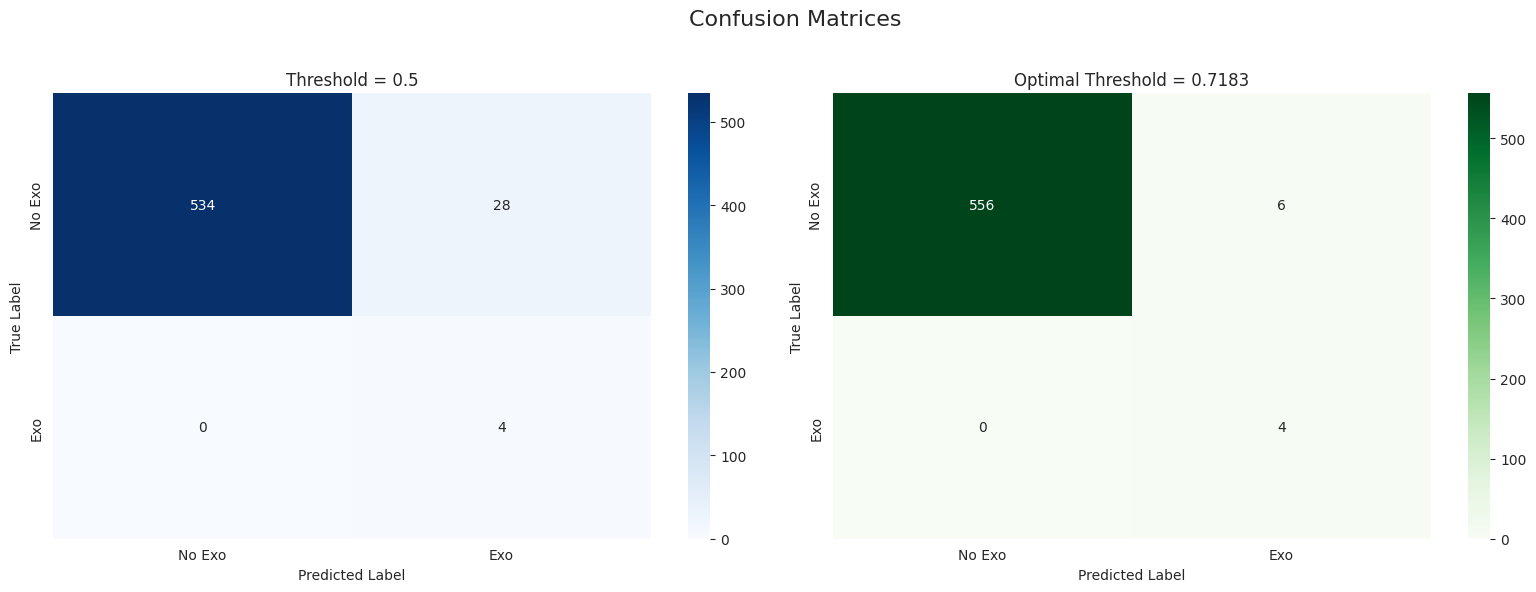

In [15]:
results_df = pd.DataFrame({
    'true_label': y_test,
    'prediction': ensemble_predictions
})

results_df.dropna(inplace=True)

generate_comprehensive_report(results_df['true_label'], results_df['prediction'])